In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as sk
from sklearn import svm
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from lightgbm import LGBMClassifier
import sklearn.ensemble as ske
import seaborn as sns
%matplotlib inline

In [35]:
# Removes a warning in sklearn that will be fixed during an update mid 2018
import warnings

if __name__ == '__main__':
    warnings.filterwarnings(action='ignore', category=DeprecationWarning)
    le = preprocessing.LabelEncoder()
    le.fit([1, 2, 2, 6])
    le.transform([1, 1, 2, 6])
    le.inverse_transform([0, 0, 1, 2])

In [36]:
df_train = pd.read_csv('./data/application_train.csv', sep=',', header=0)
df_test = pd.read_csv('./data/application_test.csv', sep=',', header=0)

print('Training set shape: ' + str(df_train.shape))
print('Test set shape: ' + str(df_test.shape))

Training set shape: (307511, 122)
Test set shape: (48744, 121)


In [37]:
m_train = df_train.shape[0]
m_test = df_test.shape[0]

df_all = pd.concat((df_train, df_test)).reset_index(drop=True)
df_all.drop(['TARGET'], axis=1, inplace=True)

print("all_data size is : {}".format(df_all.shape))

all_data size is : (356255, 121)


In [38]:
def plot_missing_ratio(df):
    missing = (df_all.isnull().sum() / len(df_all)) * 100
    missing = missing.drop(missing[missing == 0].index).sort_values(ascending=False)

    df_missing_ratio = pd.DataFrame({'Missing Ratio' :missing})

    f, ax = plt.subplots(figsize=(15, 12))
    plt.xticks(rotation='90')
    sns.barplot(x=missing.index, y=missing)
    plt.xlabel('Features', fontsize=10)
    plt.ylabel('Percent of missing values', fontsize=10)
    plt.title('Percent missing data by feature', fontsize=10)

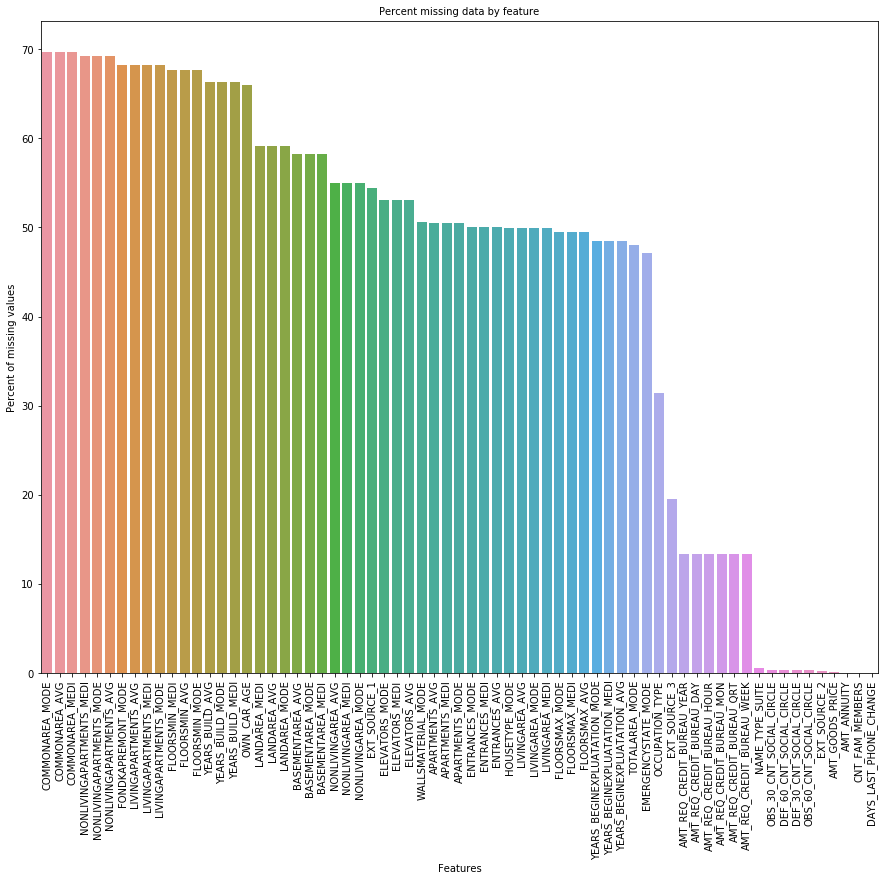

In [39]:
plot_missing_ratio(df_all)

In [40]:
categorical_columns = ['NAME_CONTRACT_TYPE',
                       'CODE_GENDER',
                       'FLAG_OWN_CAR',
                       'FLAG_OWN_REALTY',
                       'NAME_TYPE_SUITE',
                       'NAME_INCOME_TYPE',
                       'NAME_EDUCATION_TYPE',
                       'NAME_FAMILY_STATUS',
                       'NAME_HOUSING_TYPE',
                       'OCCUPATION_TYPE',
                       'WEEKDAY_APPR_PROCESS_START',
                       'ORGANIZATION_TYPE',
                       'FONDKAPREMONT_MODE',
                       'HOUSETYPE_MODE',
                       'WALLSMATERIAL_MODE',
                       'EMERGENCYSTATE_MODE']

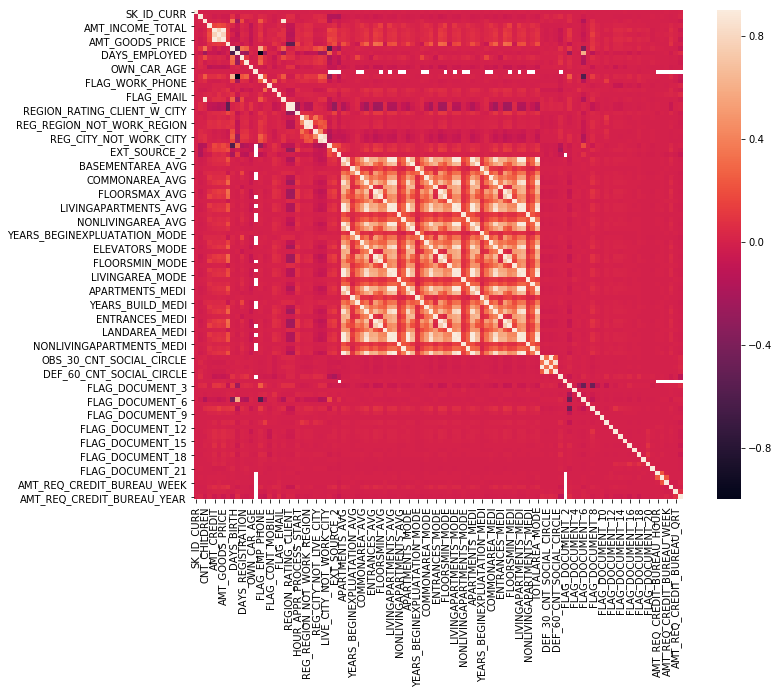

In [41]:
corrmat = df_train.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=0.9, square=True)

In [42]:
def replace_few_missing_with_default(df, max_ratio=5):

    missing = (df.isnull().sum() / len(df)) * 100
    missing = missing.drop(missing[missing == 0].index)
    few_missing = missing.drop(missing[missing > max_ratio].index)

    few_missing_columns = few_missing.index

    for col in few_missing_columns:
        df[col].fillna(df[col].value_counts().index[0], inplace = True)

    return df

In [43]:
def replace_nulls(df, categorical_columns):
    
    numeric_columns = list(df.select_dtypes(include=[np.number]).columns.values)
    
    df = replace_few_missing_with_default(df)
    df[categorical_columns] = df[categorical_columns].fillna("UNKNOWN") 
    
    """for col in categorical_columns:
        if col in numeric_columns:
            df[col] = df[col].fillna(-999) 
        else:
            df[col] = df[col].fillna("UNKNOWN") """
    
    # Replace numeric values with mean
    for col in numeric_columns:
        df[col].fillna((df[col].mean()), inplace = True)   
    
            
    return df

In [44]:
print("Number of columns with missing data: " + str(len(df_all.columns[df_all.isnull().any()].tolist())))
df_all = replace_nulls(df_all, categorical_columns)
print("Number of columns with missing data: " + str(len(df_all.columns[df_all.isnull().any()].tolist())))

Number of columns with missing data: 67
Number of columns with missing data: 0


In [45]:
def process_categorical(df, categorical_columns):
    
    # Significance of categories for target, will later try more with this
    #for col in categorical_columns:
    #   df.groupby(col).mean()['TARGET'].sort_values(ascending=False)

    df[categorical_columns] = df[categorical_columns].apply(preprocessing.LabelEncoder().fit_transform)
    df[categorical_columns] = df[categorical_columns].astype(str)
    df = pd.get_dummies(df)
    
    return df

In [46]:
df_all = process_categorical(df_all, categorical_columns)
df_all.head(1)

,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE,AMT_INCOME_TOTAL,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_YEAR,...,WALLSMATERIAL_MODE_5,WALLSMATERIAL_MODE_6,WALLSMATERIAL_MODE_7,WEEKDAY_APPR_PROCESS_START_0,WEEKDAY_APPR_PROCESS_START_1,WEEKDAY_APPR_PROCESS_START_2,WEEKDAY_APPR_PROCESS_START_3,WEEKDAY_APPR_PROCESS_START_4,WEEKDAY_APPR_PROCESS_START_5,WEEKDAY_APPR_PROCESS_START_6
0,24700.5,406597.5,351000.0,202500.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1,0,0,0,0,0,0,0,0,1


In [47]:
def rescale_data(df, mode='stand'):
    scalable_columns = list(df.select_dtypes(include=[np.float]))
    
    if mode=='norm':
        df[scalable_columns] = (df[scalable_columns] - np.min(df[scalable_columns])) \
                                / (np.max(df[scalable_columns]) - np.min(df[scalable_columns]))
    elif mode=='stand':
        df[scalable_columns] = (df[scalable_columns] - np.mean(df[scalable_columns])) \
                                / np.std(df[scalable_columns])
    return df

In [48]:
df_all = rescale_data(df_all)
print(df_all.select_dtypes(include=[np.float]).max())
df_all.select_dtypes(include=[np.float]).head(1)

AMT_ANNUITY                      15.651840
AMT_CREDIT                        8.685478
AMT_GOODS_PRICE                   9.624953
AMT_INCOME_TOTAL                522.713573
AMT_REQ_CREDIT_BUREAU_DAY        92.679813
AMT_REQ_CREDIT_BUREAU_HOUR       53.813977
AMT_REQ_CREDIT_BUREAU_MON        33.596561
AMT_REQ_CREDIT_BUREAU_QRT       355.899726
AMT_REQ_CREDIT_BUREAU_WEEK       44.740256
AMT_REQ_CREDIT_BUREAU_YEAR       13.297162
APARTMENTS_AVG                   11.505506
APARTMENTS_MEDI                  11.409036
APARTMENTS_MODE                  11.569692
BASEMENTAREA_AVG                 17.138698
BASEMENTAREA_MEDI                17.209731
BASEMENTAREA_MODE                16.796212
CNT_FAM_MEMBERS                  20.759383
COMMONAREA_AVG                   22.522720
COMMONAREA_MEDI                  22.496243
COMMONAREA_MODE                  23.053847
DAYS_LAST_PHONE_CHANGE            1.171861
DAYS_REGISTRATION                 1.412998
DEF_30_CNT_SOCIAL_CIRCLE         74.252409
DEF_60_CNT_

,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE,AMT_INCOME_TOTAL,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_YEAR,...,OBS_60_CNT_SOCIAL_CIRCLE,OWN_CAR_AGE,REGION_POPULATION_RELATIVE,TOTALAREA_MODE,YEARS_BEGINEXPLUATATION_AVG,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_AVG,YEARS_BUILD_MEDI,YEARS_BUILD_MODE
0,-0.184834,-0.454489,-0.48359,0.14489,-0.06473,-0.078258,-0.290801,-0.415563,-0.168378,-0.524991,...,0.230941,-2.774430e-12,-0.152069,-1.133442,-0.136882,-0.135737,-0.111179,-2.024891,-2.018543,-1.961917


In [49]:
def preprocess_data(df, categorical_columns):
    
    df = replace_nulls(df, categorical_columns)
    df = process_categorical(df, categorical_columns)
    df = rescale_data(df)
    df = df.drop('SK_ID_CURR', axis=1)
    
    return df

In [62]:
df_train = pd.read_csv('./data/application_train.csv', sep=',', header=0)
df_test = pd.read_csv('./data/application_test.csv', sep=',', header=0)

print('Training set shape: ' + str(df_train.shape))
print('Test set shape: ' + str(df_test.shape))

m_train = df_train.shape[0]
m_test = df_test.shape[0]

y = df_train['TARGET']
df_train.drop(['TARGET'], axis=1, inplace=True)

ids = df_test['SK_ID_CURR']

df = pd.concat((df_train, df_test)).reset_index(drop=True)
df = preprocess_data(df, categorical_columns)

df_train = df.loc[0:m_train-1]
df_test = df.loc[m_train:]

df_train['TARGET'] = y

print('Training set shape: ' + str(df_train.shape))
print('Test set shape: ' + str(df_test.shape))

print("Number of columns with missing data: " + str(len(df.columns[df.isnull().any()].tolist())))

df.head(1)

Training set shape: (307511, 122)
Test set shape: (48744, 121)


C:\Users\Administrator\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Training set shape: (307511, 250)
Test set shape: (48744, 249)
Number of columns with missing data: 0


,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,...,WALLSMATERIAL_MODE_1,WALLSMATERIAL_MODE_2,WALLSMATERIAL_MODE_3,WALLSMATERIAL_MODE_4,WALLSMATERIAL_MODE_5,WALLSMATERIAL_MODE_6,WALLSMATERIAL_MODE_7,EMERGENCYSTATE_MODE_0,EMERGENCYSTATE_MODE_1,EMERGENCYSTATE_MODE_2
0,0,0.14489,-0.454489,-0.184834,-0.48359,-0.152069,-9461,-637,0.378681,-2120,...,0,0,0,0,1,0,0,1,0,0


In [51]:
def split_data(df):
    
    df_train = df.sample(frac = 0.9, random_state = 42)
    df_val = df.drop(df_train.index)  
    
    X_train = df_train.drop(['TARGET'], axis=1).values
    y_train = df_train['TARGET'].values
    
    X_val = df_val.drop(['TARGET'], axis=1).values
    y_val = df_val['TARGET'].values
    
    return X_train, y_train, X_val, y_val

In [52]:
X_train, y_train, X_val, y_val = split_data(df_train)

In [ ]:
def train_clf(clf, X_train, y_train, X_val, y_val):
    
    clf.fit (X_train, y_train)
    
    y_act, y_pred = y_val, clf.predict_proba(X_val)
    scores = cross_val_score(clf, X_val, y_val, cv=10, scoring='accuracy')
    print("Validation Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))
    
    return clf

In [ ]:
rf_clf = ske.RandomForestClassifier(n_estimators=50)
rf_clf = train_clf(rf_clf, X_train, y_train, X_val, y_val)

In [53]:
def train_lgbm_clf(clf, X_train, y_train, X_val, y_val):
    
    clf.fit(X_train, y_train, 
            eval_set= [(X_val, y_val)],
            eval_metric='auc', 
            verbose=250, 
            early_stopping_rounds=150
           )
    
    y_act, y_pred = y_val, clf.predict(X_val)
    scores = cross_val_score(clf, X_val, y_val, cv=10, scoring='accuracy')
    print("Validation Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))
    print()
    print(classification_report(y_act, y_pred))
    
    return clf

In [54]:
lgbm_clf = LGBMClassifier(n_estimators=20000,
                          learning_rate=0.005,
                          num_leaves=70,
                          colsample_bytree=.8,
                          subsample=.9,
                          max_depth=7,
                          reg_alpha=.1,
                          reg_lambda=.1,
                          min_split_gain=.01,
                          min_child_weight=2)

lgbm_clf = train_lgbm_clf(lgbm_clf, X_train, y_train, X_val, y_val)

Training until validation scores don't improve for 150 rounds.
[250]	valid_0's auc: 0.736089
[500]	valid_0's auc: 0.741219
[750]	valid_0's auc: 0.746551
[1000]	valid_0's auc: 0.751851
[1250]	valid_0's auc: 0.755487
[1500]	valid_0's auc: 0.757617
[1750]	valid_0's auc: 0.75897
[2000]	valid_0's auc: 0.759994
[2250]	valid_0's auc: 0.760902
[2500]	valid_0's auc: 0.761527
[2750]	valid_0's auc: 0.761943
[3000]	valid_0's auc: 0.762215
[3250]	valid_0's auc: 0.762507
[3500]	valid_0's auc: 0.762758
[3750]	valid_0's auc: 0.762944
[4000]	valid_0's auc: 0.763076
[4250]	valid_0's auc: 0.763058
Early stopping, best iteration is:
[4107]	valid_0's auc: 0.76309
Validation Accuracy: 0.92 (+/- 0.00)

             precision    recall  f1-score   support

          0       0.92      1.00      0.96     28327
          1       0.52      0.02      0.04      2424

avg / total       0.89      0.92      0.89     30751



In [63]:
def predict(df, ids, clf, export_path):
    
    # Make predictions
    X = df.values
    y = clf.predict_proba(X, num_iteration=clf.best_iteration_)[:, 1]
    
    # Combine ids and predictions
    y = np.column_stack((ids, y))
    
    # Restore pandas df
    df_pred = pd.DataFrame(y)
    df_pred.columns = ["SK_ID_CURR", "TARGET"]
    
    df_pred["SK_ID_CURR"] = df_pred["SK_ID_CURR"].astype('int64')
    
    # Export
    df_pred.to_csv(export_path, sep=',', index=False)
    
    return df_pred

In [65]:
#df_test = pd.read_csv('./data/application_test.csv', sep=',', header=0)
#df_pred = predict(df_test, rf_clf, categorical_columns, './predictions/rf_pred.csv')
df_pred = predict(df_test,ids, lgbm_clf, './predictions/lgbm_pred.csv')

In [99]:
print(df_pred.sum())

SK_ID_CURR    1.354092e+10
TARGET        4.290124e+03
dtype: float64


In [66]:
print(df_pred.sum())

SK_ID_CURR    1.354092e+10
TARGET        3.828575e+03
dtype: float64


In [100]:
df_pred.head(3)

,SK_ID_CURR,TARGET
0,100001,0.035476
1,100005,0.134800
2,100013,0.015088


In [67]:
df_pred.head(3)

,SK_ID_CURR,TARGET
0,100001,0.026490
1,100005,0.111355
2,100013,0.024232
